# COMP9016 Assignment #1 (Winter 2019)
## 1 KNOWLEDGE REPRESENTATION

`NOTE:` Copied from Assignment for reference.

The purpose of this assignment is to assess the following learning outcomes:
Learning Outcomes
- LO1 Appraise domain specific formalisms used in knowledge representation schemes.
- LO2 Compare and contrast current knowledge representation approaches integrated in systems relevant to AI.
- LO3 Select, apply and evaluate a knowledge representation scheme for a specified domain.

<br>

![](./ML_R00183658_EXTRA_DIR/R00183658_reading.png)

**Important:**  
This notebook assumes the folder structure from tha latest assignment document.

- aima-python
  - AssignmentOneSubmissions
    - ML_R00183658
      - ML_R001858.ipynb
      - ML_R001858_EXTRA_DIR

In [1]:
import sys
sys.path.append('../..')
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import random

from search import *
from agents import *
from logic import *

SIZE = 5

---
---

## 1.1 BUILDING YOUR WORLD

`NOTE:` Copied from Assignment for reference.

Create a 2-dimensional world that will play host to a game to be played by agents. Provide  
context for the mechanics of the world and the conditions under which the game is complete.  
The intent of this exercise is for you to demonstrate your understanding of how a problem  
can be modeled abstractly. To this end, implement three different agents, providing a PEAS  
description of each and a rationale for their inclusion.  

- Critique the advantages and disadvantages of each agent type.
- Demonstrate each agents ability to perform or under-perform in the 2-dimensional world.
- Discuss, and evaluate, howthe agent would or would not-performin worlds of different sizes.
  
<br>

The game should be implemented in Python, you may use any of the libraries made available  
from the AIMA python repository but they must be clearly referenced. The specification for  
the Agent, Environment, and Program to enable the game to run must be included. All code  
should be in a single python file.  
Write a clear and concise description of the agent-based game. The purpose of this is to  
articulate an understanding of the underlying concepts being implemented both from a  
theoretical and practical perspective.  

<br>

![](./ML_R00183658_EXTRA_DIR/R00183658_reading.png)

### Game Overview
The implemented game lets a `Sheep` (agent) roam around a `Field` (2D environment).  
The `Field` contains other things like `Grass` and electric `Fence`s.  
The game's objective is having the sheep to find and eat all grass there is on the field.  
At the same time it should avoid the electric fence.  
<br>
**General game rules:**  
- Eating grass increases the sheep's performance. (+100)  
- Hitting the eletrictric fence penalizes the sheep's performance. (-10)  
- Roaming around also slightly decreases the sheep's performance. (-1)   
- Game ends when all grass is eaten, or sheep performance reaches 0 (dead sheep).

<br>

**Graphical representation:**

!['sheep-field'](./ML_R00183658_EXTRA_DIR/R00183658-sheep-field.png)


### Agent
The `Sheep` class acts as agent instance within the game. It is based of the AIMA `Agent` class as such inherits all its capabilities.  
The `Sheep` has been enhanced with a `tracker` and `performance_history` for visualization purposes.  
The same class is used for all agent types, but not all agent types use all components, e.g. the Simplex Agent does not use the model.  
According to the game dynamics the sheep can `eat` Grass and experience `shock` by a Fence.

According the literature, an agent receives percepts from the environemnt through its sensors and acts with actions (through actuators where available).  
For each agent type a special `agent program` implements the mapping from environment percepts to agent actions.


### Environment
The `Field` class acts as the environment for the game. It is based of the AIMA `Environment` class as such inherits all its capabilities.  
The code cell below shows any Environment function that was **implemented** or **altered** from the parent class.

- An agent is placed into the field with an initial performance of 100.
- The game `is_done` when all grass is gone or no agent is alive.
- Each step in the game is a penalty of -1 on the agent's performance.
- Upon action `eat` the agent gets rewarded with a +100 performance boost
- Upon action `shock` the agent gets penalized with -10 performance degradation. The shock will also place the agent back into the previous loaction.
- The `force_shock` switch was implemented to demonstrate how a random agent would perform (i.e. the environment is simulation the missing percept).

The target environment is:
- partially observable
- single agent
- deterministic
- sequential
- static
- discret


### Things
`Grass` and `Fence` are based of AIMA class `Thing`. They represent game components the agent has to interact with.


### PEAS
Here I describe the overall PEAS model of the agent/environment interaction.

**P**erformance:
- Performance/health counter. Initially set to 100.
- Agent has to find all Grass locations with its performance budget.
- Game over when sheep runs out of performance or all grass has been eaten.
- Higher agent health = higher agent performance in completing the game.

**E**nvironment:
- 2d world (NxN)
- 1 agent, x fence, y grass

**A**ctuators:
- 'feet' to move: `up`, `down`, `left`, `right`
- 'mouth' to `eat` grass

**S**ensors:
- 'nose' to smell `Grass`
- 'skin' to feel `Fence`

<br>

In [2]:
class Grass(Thing):
    pass

class Fence(Thing):
    pass

class Model:
    def __init__(self):
        self.model = {}
        self.model['WorldSize'] = SIZE
        self.model['painful_states'] = []
        self.model['boring_states'] = []
        
class Sheep(Agent):
    def __init__(self, program=None, agent_type=None):
        super().__init__(program)
        self.tracker = []
        self.model = Model()
        self.agent_type = agent_type
        self.performance_history = []
        
    def get_location(self):
        return self.location
    
    def track(self):
        self.tracker.append(self.location)
    
    def eat(self, thing):
        ''' returns True upon success or False otherwise'''
        if isinstance(thing, Grass):
            return True
        return False
    
    def shock(self, thing):
        ''' returns True upon success or False otherwise'''
        if isinstance(thing, Fence):
            return True
        return False

class Field(Environment):
    def __init__(self, size, force_shock=False):
        super().__init__()
        self.size = size
        self.force_shock = force_shock
        
    def percept(self, agent):
        '''return a list of things that are in our agent's location'''
        things = self.list_things_at(agent.location)
        return (agent.location, things)

    def execute_action(self, agent, action):
        """Change the world to reflect this action. (Implement this.)"""
        if self.force_shock:
            if self.list_things_at(agent.location, tclass=Fence):
                agent.performance -=10
        
        if action in ['up', 'down', 'left', 'right']:
            agent.location = self.move_agent(agent, action)
        elif action == "eat":
            items = self.list_things_at(agent.location, tclass=Grass)
            if len(items) != 0:
                if agent.eat(items[0]):
                    agent.performance += 100
                    #print(' > {} ate {} at location {}'
                    #      .format(str(agent)[1:-1], str(items[0])[1:-1], agent.location))
                    self.delete_thing(items[0])
        elif action == "shock":
            items = self.list_things_at(agent.location, tclass=Fence)
            if len(items) != 0:
                if agent.shock(items[0]):
                    #agent.shock(items[0])
                    agent.performance -=10
                    agent.location = agent.tracker[-2]
        
        self.agent_tick(agent)

    def agent_tick(self, agent):
        agent.performance -= 1
        if agent.performance <= 0:
            agent.performance = 0
            agent.alive = False
        agent.performance_history.append(agent.performance)

    def has_grass(self):
        has_grass = False
        for item in self.things:
            if isinstance(item, Grass):
                has_grass = True
        return has_grass
        
    def is_done(self):
        """By default, we're done when we can't find a live agent."""
        return not any(agent.is_alive() for agent in self.agents) or not(self.has_grass())

    def step(self):
        """Run the environment for one time step. If the
        actions and exogenous changes are independent, this method will
        do. If there are interactions between them, you'll need to
        override this method."""
        if not self.is_done():
            actions = []
            for agent in self.agents:
                if agent.alive:
                    agent.track()
                    if agent.agent_type == 'model':
                        actions.append(agent.program(self.percept(agent), agent.model))
                    elif agent.agent_type == 'goal':
                        actions.append(agent.program(self.percept(agent), agent.model, agent.performance))
                    else:
                        actions.append(agent.program(self.percept(agent)))
                else:
                    actions.append("")
            for (agent, action) in zip(self.agents, actions):
                self.execute_action(agent, action)
            self.exogenous_change()
            
    def add_thing(self, thing, location=None):
        """Add a thing to the environment, setting its location. For
        convenience, if thing is an agent program we make a new agent
        for it. (Shouldn't need to override this.)"""
        if not isinstance(thing, Thing):
            thing = Sheep(thing)
        if thing in self.things:
            print("Can't add the same thing twice")
        else:
            thing.location = location if location is not None else self.default_location(thing)
            self.things.append(thing)
            if isinstance(thing, Agent):
                thing.performance = 100
                self.agents.append(thing)

    def move_agent(self, agent, action):
        x, y = agent.location[0], agent.location[1]
        if action == 'up':
            if (x - 1) > 0: x -= 1
        elif action == 'down':
            if (x + 1) <= self.size: x += 1
        elif action == 'left':
            if (y - 1) > 0: y -= 1
        elif action == 'right':
            if (y + 1) <= self.size: y += 1
        
        return [x, y]

<br>

![](./ML_R00183658_EXTRA_DIR/R00183658_reading.png)

### Playing and visualization helper functions

Below you find a few helper functions to run the game and to visualize the agent's success in the environment.  
`_1play`: This method plays the game with a fixed setup to allow comparison between different agent types.  
`_1000plays`: This method plays the fixed `_1play` scenario 1000 times to allow comparison between different agent types and identification of agent behaviour patterns.  
`_1play_random`: To demonstrate the different agents can play a random world too. The method places 1 agent and for any other field either Grass or Fence with 20% probability.  
`AgentHeatMap`: Visualize how often an agent visited a certain location of the field and performance history.

In [3]:
def AgentHeatMap(size, tracker, agent=None, random_game=None):
    map = np.zeros((size, size))
    for location in tracker:
        x, y = location[0]-1, location[1]-1
        map[x][y] +=1
        
    if not agent:
        #fig, ax = plt.subplots()
        fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5,5))

        im = ax1.imshow(map)
        # Loop over data dimensions and create text annotations.
        for i in range(size):
            for j in range(size):
                text = ax1.text(j, i, map[i, j], ha="center", va="center", color="w")
        
        ax1.set_title('Agent/Env heatmap')        
        ax1.set_xlabel('x')
        ax1.set_ylabel('y')
    
    if agent:
        fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

        im = ax1.imshow(map)
        # Loop over data dimensions and create text annotations.
        for i in range(size):
            for j in range(size):
                text = ax1.text(j, i, map[i, j], ha="center", va="center", color="w")
        
        ax2.plot(agent.performance_history)
        
        ax1.set_title('Agent/Env heatmap')        
        ax1.set_xlabel('x')
        ax1.set_ylabel('y')
        ax2.set_title('Agent Performance History')
        ax2.set_xlabel('Step')
        ax2.set_ylabel('Performance')
        
    plt.show()
    
    if not random_game:
        steps_on_fence = map[0][2] + map[1][2] + map[2][2]
        print('\nSheep spent {} steps on electric fence.\n'.format(steps_on_fence))

def _1play(agent, size=SIZE, force_shock=False):
    field = Field(size=size, force_shock=force_shock)
    field.add_thing(agent, [1,1])
    field.add_thing(Grass(), [1,4])
    field.add_thing(Grass(), [1,5])
    field.add_thing(Grass(), [2,4])
    field.add_thing(Grass(), [2,5])
    field.add_thing(Fence(), [1,3])
    field.add_thing(Fence(), [2,3])
    field.add_thing(Fence(), [3,3])
    field.run()

def _1play_random(agent, size, force_shock=False):
    field = Field(size=size, force_shock=force_shock)
    
    agent_placed = False
    
    for x in range(1, size+1):
        for y in range(1, size+1):
            r = random.uniform(0, 1)
            if r < 0.1 and not agent_placed:
                field.add_thing(agent, [x,y])
                agent_placed = True
            elif 0.1 <= r < 0.3:
                field.add_thing(Grass(), [x,y])
            elif 0.3 <= r < 0.5:
                field.add_thing(Fence(), [x,y])
    
    field.run()
    
def _1000plays(size=SIZE, agent_type=None, force_shock=False):
    _results = []
    _performances = []
    _success_steps = []
    
    games=1000
    
    for i in range(games):
        if agent_type == 'random':
            sheep = Sheep(RandomAgentProgram(actions=['up', 'down', 'left', 'right', 'eat']))
        elif agent_type == 'simplex':
            sheep = Sheep(SimplexAgentProgram)
        elif agent_type == 'model':
            sheep = Sheep(ModelAgentProgram, agent_type=agent_type)
        elif agent_type == 'goal':
            sheep = Sheep(GoalModelAgentProgram, agent_type=agent_type)
            
        _1play(sheep, size=SIZE, force_shock=force_shock)
        _results.append(sheep.tracker)
        _performances.append(sheep.performance)
        
        if sheep.performance > 0:
            _success_steps.append(len(sheep.tracker))
    
    success_rate = (len(_performances) - _performances.count(0)) / len(_performances)
    success_perf = (list(filter((0).__ne__, _performances)))
    game_steps = [len(i) for i in _results]
    if success_perf:
        avg_perf_on_success = sum(success_perf) / len(success_perf)
        avg_step_on_success = sum(_success_steps) / len(_success_steps)
        print('\nAverage  performance when successful:', int(avg_perf_on_success))
        print('Average  game length when successful: {} steps'.format(int(avg_step_on_success)))
        print('Shortest game length when successful: {} steps'.format(min(_success_steps)))   #game_steps
    print('Success rate: {}\n'.format(success_rate))    
    
    total_tracker = []
    for result in _results:
        total_tracker += result
    
    AgentHeatMap(size=SIZE, tracker=total_tracker)

---

![](./ML_R00183658_EXTRA_DIR/R00183658_reading.png)

### Agents
The following agents are demonstrated:
- Random Agent
- Simple-Reflex Agent
- Model-based Reflex Agent
- Goal & Model-based Reflect Agent

**Pleas note**, that for comparison reasons the agents are first evaluated using the **same static environments** from the graphical  
representational above.

<br>

### Random Agent
The Random Agent is the most simplistic agent possible. Its agent program takes a list of actions and randomly chooses one for execution.  
Even essential actions like eating in a location with Grass rely on randomness.  
This agent type does not consider percepts from the environment and will perform poorly in a hostile environment.  
Realistically, the random agent is even inappropriate for solving this environment and will perform even worse in larger worlds.

**PEAS:**  
The task model has been defined earlier. Here I only present the agent transition model.

```
Percept: None
Action:  chose randomly from available actions => ['up', 'down', 'left', 'right', 'eat']
```

In [4]:
def RandomAgentProgram(actions):
    """An agent that chooses an action at random, ignoring all percepts.
    """
    return lambda percept: random.choice(actions)

<br>

![](./ML_R00183658_EXTRA_DIR/R00183658_reading.png)

Run the next cell multiple times for playing the Random Agent.


Game completed in 196 steps.
Sheep performance: 304



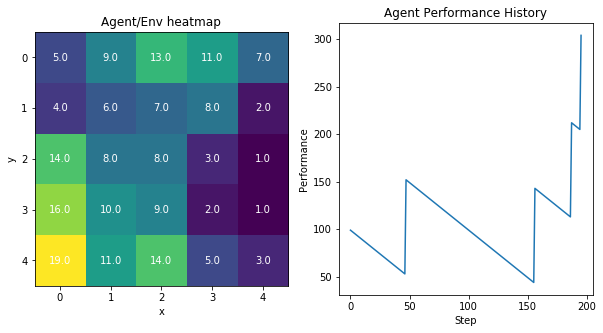


Sheep spent 28.0 steps on electric fence.



In [5]:
sheep = Sheep(RandomAgentProgram(actions=['up', 'down', 'left', 'right', 'eat']))
_1play(sheep, size=SIZE)

print('\nGame completed in {} steps.'.format(len(sheep.tracker)))
print('Sheep performance: {}\n'.format(sheep.performance))

AgentHeatMap(size=SIZE, agent=sheep, tracker=sheep.tracker)

<br>

![](./ML_R00183658_EXTRA_DIR/R00183658_reading.png)

**NOTE:**  
The lack of perception lets the sheep randomly roam around the environment and eventually eat all grass.  
Game completion in reality would be very unrealistic. The sheep would die from too much electricity.

<br>

Next, let's play the Random Agent 1000 times. Notice how the simulation in lack of perception believes it can successfully  
complete **~40-45%** of the games.


Average  performance when successful: 296
Average  game length when successful: 203 steps
Shortest game length when successful: 23 steps
Success rate: 0.428



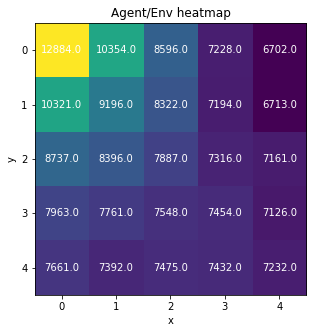


Sheep spent 24805.0 steps on electric fence.



In [6]:
_1000plays(agent_type='random')

<br>

![](./ML_R00183658_EXTRA_DIR/R00183658_reading.png)

Next, let's simulate the performance under consideration of electrical shocks and the penalty involved.  
Notice how the success rate dropped to ~10%.  
This is still an unrealistic simulation as the sheep also magically runs through the Fence.


Average  performance when successful: 277
Average  game length when successful: 110 steps
Shortest game length when successful: 23 steps
Success rate: 0.094



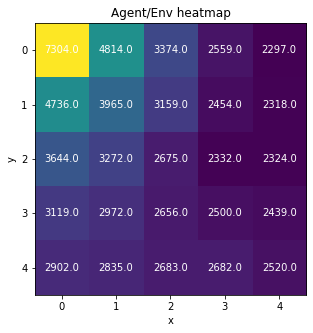


Sheep spent 9208.0 steps on electric fence.



In [7]:
_1000plays(agent_type='random', force_shock=True)

<br>

![](./ML_R00183658_EXTRA_DIR/R00183658_reading.png)

**Summary**:  

The Random Agent is a pretty poor selection to complete this game, but helped to quickly verify some of the agent & environment interactions.

---

![](./ML_R00183658_EXTRA_DIR/R00183658_reading.png)

### Simple-Reflex Agent
Unlike the Random Agent, the Simple Reflex Agent considers the actual percepts provided by the environment.  
The most notable improvement is that now the sheep is able to **always** eat when it enters a grassy location as it can react on the environments signal.  
This will greatly enhance the sheeps performance in completing the game. The sheep will also properly react with a `shock` when hitting a Fence.

The move selection from otherwise empty locations is still randomly chosen, which makes this agent also rather unsuitable for larger worlds.

**PEAS:**  
The task model has been defined earlier. Here I only present the agent transition model.

Percept | Action
--- | :---:
Grass | eat
Fence | shock
None  | random move ['up', 'down', 'left', 'right']


In [8]:
def SimplexAgentProgram(percepts):
    '''Returns an action based on the Sheep's percepts'''
    for p in percepts[1]:      # percept: ([1, 3], [<Sheep>, <Fence>])
        if isinstance(p, Grass):
            return 'eat'
        elif isinstance(p, Fence):
            return 'shock'
        else:
            choice = random.choice((1,2,3,4)) # 1-up, 2-down, 3-left, 4-right
    if choice == 1:
        return 'up'
    elif choice == 2:
        return 'down'
    elif choice == 3:
        return 'left'
    elif choice == 4:
        return 'right'

<br>

![](./ML_R00183658_EXTRA_DIR/R00183658_reading.png)

Run the next cell multiple times for playing the Simple Reflex Agent. Completing this sample static world still requires a bit of luck.


Game completed in 240 steps.
Sheep performance: 0



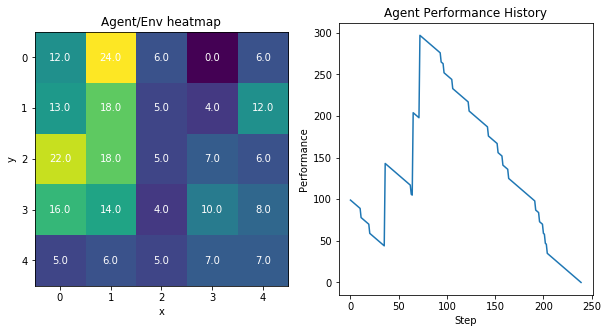


Sheep spent 16.0 steps on electric fence.



In [11]:
sheep = Sheep(SimplexAgentProgram)
_1play(sheep, size=SIZE)

print('\nGame completed in {} steps.'.format(len(sheep.tracker)))
print('Sheep performance: {}\n'.format(sheep.performance))

AgentHeatMap(size=SIZE, agent=sheep, tracker=sheep.tracker)

<br>

![](./ML_R00183658_EXTRA_DIR/R00183658_reading.png)

**NOTE:**  
Subsequent executions of the _1play show that the sheep often is unable to complete the game. The main cause is running too often  
into the electric fence and thereby losing energy required to find a way around the fenced area.

<br>

Next, let's play the Simple Reflex Agent 1000 times. Notice that with respect to the electric fences, whose location the sheep  
can't remember, it is able to complete **~15-19%** of the games. 


Average  performance when successful: 379
Average  game length when successful: 77 steps
Shortest game length when successful: 26 steps
Success rate: 0.178



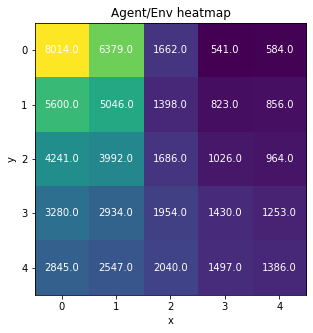


Sheep spent 4746.0 steps on electric fence.



In [12]:
_1000plays(agent_type='simplex')

<br>

![](./ML_R00183658_EXTRA_DIR/R00183658_reading.png)

**Summary:**

The Simple Reflex program allows the agent to make appropriate actions in certain situations, like upon the Grass percept.  
This highlights that a proper sensor-actuator mapping has a **positive effect on the agent's performance**.

A main weakness is still the fact that the sheep does not remember which state should be avoided, which often causes a  
rapid depletion of performance.

---

![](./ML_R00183658_EXTRA_DIR/R00183658_reading.png)

### Model-based Agent

Now the Model-based agent will be used to further improve the agent's performance. This agent type keeps state of the world that  
currently is not observable and guides the agent's decision making process.

Using the Model class the sheep tracks either `borings_states` or `painful_states`.   

`painful_states` represent locations where the sheep experienced a shock. For future actions the sheep wants to avoid these at any price.  
`borings_states` represent locations with no special percept. Knowing about these low-value/low-utility locations the sheep can optimize  
its decisions, e.g. avoid a boring state when other actions can lead the agent to yet unexplored locations. The sheep still randomly chooses  
from boring_states, if all potential next states already have been explored to avoid the sheep getting stuck.

Giving the agent a memory to track state of the world and especially record locations it has visited before can greatly enhance an agent's  
capability to survive in larger environments, because it is less likely to loop around in visited states as long as unexplored successor  
states/locations exist on the map.

**PEAS:**  
The task model has been defined earlier. Here I only present the agent transition model.

Percept | Action | Model
--- | :---: | :---:
Grass | eat | None
Fence | shock | Add location to painful_states 
None  | Typically random move ['up', 'down', 'left', 'right'] <p><p> Model: <br> 1. Avoid to action that lead to known painful_state <br> 2. Prefer unkown locations over boring_states | Add location to boring_states

In [13]:
def ModelAgentProgram(percept, model):
    def rule_match(model, location):
        result = []
        boring = []
    
        for move in ['up', 'down', 'left', 'right']:
            new_location = location.copy()
            if move == 'up':
                new_location[0] -= 1
            if move == 'down':
                new_location[0] += 1
            if move == 'left':
                new_location[1] -= 1
            if move == 'right':
                new_location[1] += 1
            
            if is_allowed_location(new_location):
                if new_location not in model.model['painful_states']:
                    if new_location in model.model['boring_states']:
                        boring.append(move)
                        if random.random() > 0.8:
                            result.append(move)
                    else:
                        result.append(move)

        #
        # If all new_locations are painful or boring, then consider boring states
        #
        if len(result) == 0:
            result = boring.copy()
        
        return result
    
    def is_allowed_location(location):
        return (1 <= location[0] <= SIZE) and (1 <= location[1] <= SIZE)

    location, status = percept
    
    ## Update state/model here
    for p in status:      # percept: ([1, 3], [<Sheep>, <Fence>])
        if isinstance(p, Grass):
            return 'eat'
        elif isinstance(p, Fence):
            if location not in model.model['painful_states']:
                model.model['painful_states'].append(location)
            return 'shock'
        else:
            if location not in model.model['boring_states']:
                model.model['boring_states'].append(location)

    possible_choises = rule_match(model, location)      
    choice = random.choice(range(len(possible_choises)))
    return possible_choises[choice]

<br>

![](./ML_R00183658_EXTRA_DIR/R00183658_reading.png)

Run the next cell multiple times for playing the Model based Agent.  
Notice how the sheep enters each well-known Fence location at most once (2,0  2,1  2,2). While playing note how often show sheep completes the game.


Game completed in 30 steps.
Sheep performance: 460



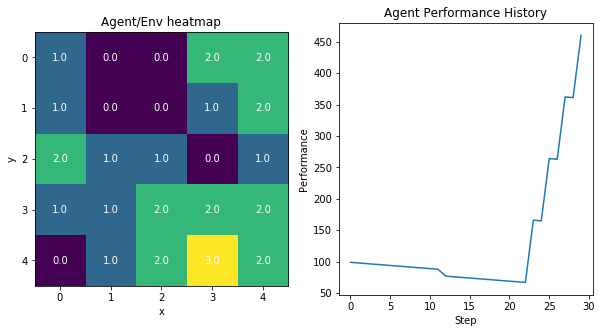


Sheep spent 1.0 steps on electric fence.



In [14]:
sheep = Sheep(ModelAgentProgram, agent_type='model')
_1play(sheep, size=SIZE)

print('\nGame completed in {} steps.'.format(len(sheep.tracker)))
print('Sheep performance: {}\n'.format(sheep.performance))

AgentHeatMap(size=SIZE, agent=sheep, tracker=sheep.tracker)

<br>

![](./ML_R00183658_EXTRA_DIR/R00183658_reading.png)

Next, let's play the Model based Agent 1000 times.  
Notice that by memorizing painful states and avoiding them for future actions, the sheep completes **~85-88%** of the games.  
In addition, the heatmap greatly visualizes how the sheep avoids the locations with electric fences.


Average  performance when successful: 432
Average  game length when successful: 44 steps
Shortest game length when successful: 15 steps
Success rate: 0.873



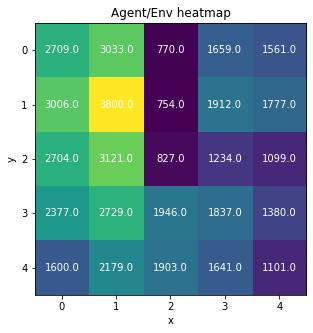


Sheep spent 2351.0 steps on electric fence.



In [15]:
_1000plays(agent_type='model')

---

![](./ML_R00183658_EXTRA_DIR/R00183658_reading.png)

### Goal-based Agent
Now, let's see if the agent performance can be further enhanced by adding goals, i.e. agents interests.  
Goal based agents usually have a deeper understanding of the enrvironment that reache beyond the percepts and world model.

Based on the Model based agent above I introduced 2 goals into the agent program:
- The sheep does not eat if its performance it above the `eat_threshold`. It will feel miserable otherwise and produce nothing but methane.
- Move `right` once the sheep's performance drops below the `eat_threshold`. This gives the sheep a boost to re-find the grass on the right side of the field.


**PEAS:**  
The task model has been defined earlier. Here I only present the agent transition model.

Percept | Action | Model
--- | :---: | :---:
Grass | eat | None
Fence | shock | Add location to `painful_states` 
None  | Typically random move ['up', 'down', 'left', 'right'] <p><p> **Model:** <br> 1. Avoid to action that lead to known `painful_state` <br> 2. Prefer unkown locations over `boring_states` <p><p> **Goal:** <br> 1. Only eat when `eat_threshold` is crossed <br> 2. Prefer move `right` when `eat_threshold` is crossed | Add location to `boring_states`

In [16]:
def GoalModelAgentProgram(percept, model, performance):
    goals = {
        'eat_threshold': 175,
        'action': 'right',
    }
    
    def rule_match(model, location):
        result = []
        boring = []
        
    
        for move in ['up', 'down', 'left', 'right']:
            new_location = location.copy()
            if move == 'up':
                new_location[0] -= 1
            if move == 'down':
                new_location[0] += 1
            if move == 'left':
                new_location[1] -= 1
            if move == 'right':
                new_location[1] += 1
            
            if is_allowed_location(new_location):
                if new_location not in model.model['painful_states']:
                    if new_location in model.model['boring_states']:
                        boring.append(move)
                        if random.random() > 0.8:
                            result.append(move)
                    else:
                        result.append(move)

        #
        # If all new_locations are painful or boring, then consider boring states
        #
        if len(result) == 0:
            result = boring.copy()
        
        return result
    
    def is_allowed_location(location):
        return (1 <= location[0] <= SIZE) and (1 <= location[1] <= SIZE)
    
    def validate_eat_action(performance):
        if performance < goals['eat_threshold']:
            return True

    def validate_move_action(performance, possible_choises):
        if performance < goals['eat_threshold']:
            if goals['action'] in possible_choises:
                return [goals['action']]
        
        return possible_choises
        
    location, status = percept

    for p in status:      # percept: ([1, 3], [<Sheep>, <Fence>])
        if isinstance(p, Grass):
            if validate_eat_action(performance):
                return 'eat'
        elif isinstance(p, Fence):
            if location not in model.model['painful_states']:
                model.model['painful_states'].append(location)
            return 'shock'
        else:
            if location not in model.model['boring_states']:
                model.model['boring_states'].append(location)
    
    possible_choises = rule_match(model, location)
    possible_choises = validate_move_action(performance, possible_choises)
    
    choice = random.choice(range(len(possible_choises)))
    return possible_choises[choice]

<br>

![](./ML_R00183658_EXTRA_DIR/R00183658_reading.png)

Run the next cell multiple times for playing the Goal based agent. 


Game completed in 211 steps.
Sheep performance: 259



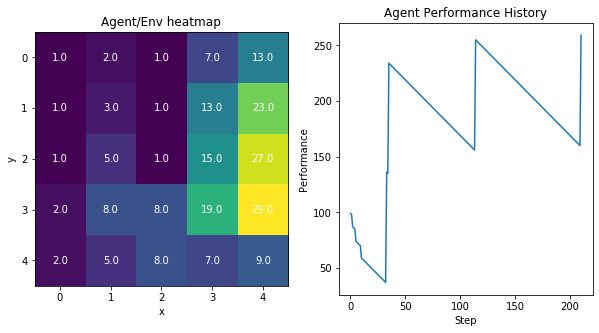


Sheep spent 3.0 steps on electric fence.



In [17]:
sheep = Sheep(GoalModelAgentProgram, agent_type='goal')
_1play(sheep, size=SIZE)

print('\nGame completed in {} steps.'.format(len(sheep.tracker)))
print('Sheep performance: {}\n'.format(sheep.performance))

AgentHeatMap(size=SIZE, agent=sheep, tracker=sheep.tracker)

<br>

![](./ML_R00183658_EXTRA_DIR/R00183658_reading.png)

Let's now see how our goal based sheep performs in the static environemt 1000 times.

**~95-97%**: So indeed roughly knowing that the grass is located at the right side of the field helps the sheep to further  
improve its success rate in solving the game, even when introducing additional eating constraints.  

With 1000 games one also notices a longer runtime, as the sheep needs to wait for its performance to decrease until it  
feels hungry again.  

One could certainly further improve the goal based agent by using **search** to reach goals.


Average  performance when successful: 232
Average  game length when successful: 237 steps
Shortest game length when successful: 197 steps
Success rate: 0.968



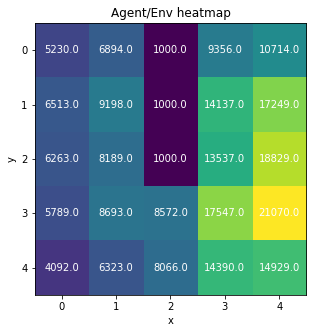


Sheep spent 3000.0 steps on electric fence.



In [18]:
_1000plays(agent_type='goal')

---

![](./ML_R00183658_EXTRA_DIR/R00183658_reading.png)

### Play in a random environment

Finally, after the different agents have been implemented and tested against a well defined environment,  
let's verify that the agents do work in a random world as well. Herefore, we  overwrite the global `SIZE`  
variable and we run a single random game `_1play_random`.  

As the above used goal of expecting grass at the right side of the field is not useful in a random environment,  
this play will be made with the Model-based agent and risks the sheep to burst from overeating.

Please run the following cells multiple times.


Game completed in 554 steps.
Sheep performance: 1696



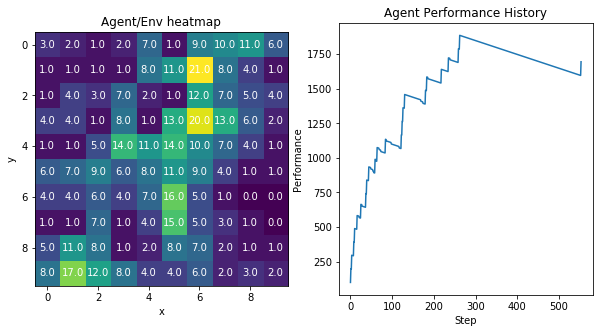

In [19]:
SIZE = 10

sheep = Sheep(ModelAgentProgram, agent_type='model')
_1play_random(sheep, size=SIZE)

print('\nGame completed in {} steps.'.format(len(sheep.tracker)))
print('Sheep performance: {}\n'.format(sheep.performance))

AgentHeatMap(size=SIZE, agent=sheep, tracker=sheep.tracker, random_game=True)

<br>

![](./ML_R00183658_EXTRA_DIR/R00183658_reading.png)

**Fun Finding:**

An interesting scenario has been observed during testing. The sheep was completely fenced and could not complete  
the game. The ModelAgentProgram based agent tried all possible locations to escape while honoring the Model state  
to not step into a known bad location twice.

So evolution did very well when sheep learned to jump fences...

!["Fenced Agent"](./ML_R00183658_EXTRA_DIR/R00183658_fenced_sheep2.png)

---
---

## 1.2 SEARCHING YOUR WORLD

**1.**  Formulate a well defined problem statement and identify a goal-state under which your game is complete. Why is this important to search? As part of your solution you should be including the initial state, the set of actions, the transition model, a goal test function and a path cost function.
<p>

<br>

![](./ML_R00183658_EXTRA_DIR/R00183658_reading.png)

Let us continue with the static 5x5 setup, as we evaluated the agents' performances in this scenario thoroughly.  
We saw with the Model-based agent `_1000plays` execution, that the successful game completion was ~85-87%.  
But the sample screenshot below highlights also that the average game length on successful completion is 44 steps,  
whereas the shortest game instance was completed in 16 steps only. 

![](./ML_R00183658_EXTRA_DIR/R00183658_result_model_1000.png)

<br>

![](./ML_R00183658_EXTRA_DIR/R00183658_reading.png)

### Search
The use of search can help our agent to make better than random move operations in our 2D world and complete the game in the  
fewest steps possible. Search represents a component of an AI agent, which handles planning steps ahead and requires the following input:
- **Initial state:** Describes the world at the beginning of the search
- **Goal state:** Describes the target outcome for which search is requested to find an action sequence.
- **Actions:** Defines the different actions also available to an agent for completing the world
- **Transition Model:** Describes how the world is expected to change given simulated actions, i.e. creates successor state in search.
- **Goal Test Function:** Checks whether a state is equal to the goal state. If True, search is completed.
- **Path Cost Function:** Assigns a cost for transiting from 1 state into a successor state that matches the agents performance measure, e.g. shortest path from initial state to goal state.

By providing the full initial state of the problem to the search, we make our environment fully observable so that based on to above components of search a deterministic solution can be found.

For the Sheep/Field search the components are defined as follows:
- **Initial state:** Tuple of world state and agent location. The world state defines things of interest in the environment: Grass and Fences.
- **Goal State:** The goal represents the world the search should reach, i.e. no more grassy locations. Fences remain untouched.
- **Actions**: Simulate agent actions to guide search. Return possible `moves` if location is empty. Return `eat` when location has grass. Return `None` when location has Fence.
- **Transition Model:** Takes all actions to create successor states in search. `None` stops a tree -> no successor state. `eat` updates state and clears respective location. Else update agents location for successor state.

In [20]:
class P(Problem):
    def __init__(self, initial=None, goal=None):
        #self.initial = initial
        #self.goal = goal
        self.solution = None
        
        self.initial = ((
            0, 0, 'F', 'G', 'G',
            0, 0, 'F', 'G', 'G',
            0, 0, 'F', 0, 0,
            0, 0, 0, 0, 0,
            0, 0, 0, 0, 0),
            (1, 1)
        )

        self.goal  = (
            '0', '0', 'F', '0', '0',
            '0', '0', 'F', '0', '0',
            '0', '0', 'F', '0', '0',
            '0', '0', '0', '0', '0',
            '0', '0', '0', '0', '0'
        )


    def actions(self, state):
        action_list = ['left', 'right', 'up', 'down']
        #action_list = ['up', 'right', 'down', 'left']
        location = state[1]
        
        dim = np.sqrt(len(state[0])).astype(int)
        state = np.array(state[0]).reshape(dim,dim)
                
        #
        # If the sheep is at the edge of the world remove impossible moves
        #
        if location[0] == 1: action_list.remove('up')
        if location[0] == state.shape[0]: action_list.remove('down')
        if location[1] == 1: action_list.remove('left')
        if location[1] == state.shape[1]: action_list.remove('right')
        
        #
        # Handle Grass 'G' and Fence 'F'
        # 'G' => eat
        # 'F' => electrical shock is not good for the sheep, 
        #        it will loose its mind and this search path has to stop
        #
        loc_row, loc_col = location[0], location[1]
        if state[loc_row - 1][loc_col - 1] == 'G': 
            action_list = ['eat']
        if state[loc_row - 1][loc_col - 1] == 'F': action_list = []
                    
        return action_list 
    
    def result(self, state, action):
        '''
        For the search tree node creation we receive on of the parent nodes' action
        and return a result based on the search transition model. 
        The result includes the updated world state and location of the simulated agent.
        The 'actions' method ensure that only valid and possible actions are provided 
        to new nodes.
        '''
        
        #
        # Prepare state matrix and location for easier manipulation
        #
        location = state[1]
        dim = np.sqrt(len(state[0])).astype(int)
        state = np.array(state[0]).reshape(dim,dim)
        loc_row, loc_col = location[0], location[1]

        #
        # State transition model:
        #    - Update world if grass is eaten
        #    - Update simulated agent location
        #
        if action == 'eat': state[loc_row - 1][loc_col - 1] = 0
        if action == 'up': loc_row -= 1
        if action == 'down': loc_row += 1
        if action == 'left': loc_col -= 1
        if action == 'right': loc_col += 1
        
        #
        # Prepare return data: state and location
        #
        state = state.flatten()
        location = (loc_row, loc_col)
        
        return (tuple(state), location)

    def goal_test(self, state):
        if isinstance(self.goal, list):
            return is_in(state, self.goal)
        else:
            dim = np.sqrt(len(state[0])).astype(int)
            return state[0] == self.goal

    def print_solution(self):
        node, actions_executed = self.solution, []

        while node.parent:
            actions_executed.append((node, node.action))
            node = node.parent
        
        print("Solution state:  ", self.solution)
        print("Solution cost :  ", self.solution.path_cost)
        print("Solution nodes:  ", _ids)
        print("Solution path :  ")

        for n in actions_executed[::-1]:
            print('    > Reached Node {} with action {}'.format(n[0], n[1]))

    def get_seq(self):
        node, actions_executed = self.solution, []
        seq = []

        while node.parent:
            seq.insert(0, node.action)
            node = node.parent

        return seq 

**2.**  
Select three uninformed search techniques and discuss their appropriateness to your world under appropriate headings for search.
<p>

<br>

![](./ML_R00183658_EXTRA_DIR/R00183658_reading.png)

According to the agent we simulate the actions + transitional model of the search allows state loops **(redundant path)** which cause tree search algorithms to run infinitely.  
Therefore **graph search** solutions must be used for this environment to avoid transiting into previously **explored states**.

**Depth-first Graph Search (DFS)**:  
- Operation: DFS uses a **LIFO** (Last in First Out) queue. This means the last created state will immediately be expanded until a graph loop is encountered.
- **Result will differ** based on the **order of the action_list**.
- It is **complete** for the given finite state space of the sheep world.
- It is **not optimal**, because by expanding the deepest node first everytime, the search algorithm will always take the the first action from the action_list for the next expansion and may find longer than optimal paths for the sheep to eat all grass.
- Complexity is bounded by state space, and negligible for a 5x5 world.

**Breath-first Graph Search (BFS)**: 
- Operation: BFS uses a **FIFO** (First in First Out) queue. Hence, all state for a given depths are evaluated first before depth+1 .
- It is **complete** for the given finite state space of the sheep world.
- Search is **optimal**, the sheep will find the shortest solution to eat all grass.
- Complexity is bounded by state space, and negligible for a 5x5 world.

**Best First Graph Search**:
- Implements a priority queue and allows us to guide search to minimize a specific value most valuable for reaching thw goal.
- Here we want to **optimize the minimization of locations in search state holding Grass. Hence, states with lower number of Grass are prioritized for expansion.**
- **Complete** and **optimal** for Sheep world example.
- Time and Space complexity much less than Breath-first Graph Search

**3.**  
Implement the three uninformed search techniques discussed for your world.  
Discuss the results.

<br>

![](./ML_R00183658_EXTRA_DIR/R00183658_reading.png)

### The search Node
(from AIMA repo, slightly modified)

In [21]:
from itertools import count

#########################################################################
#
# class Node is copied from AIMA code
# 
# A micro change was implemented in __init__ to increase an iterator 
# counter every time a new node is generated.
#
#########################################################################

class Node:
    """A node in a search tree. Contains a pointer to the parent (the node
    that this is a successor of) and to the actual state for this node. Note
    that if a state is arrived at by two paths, then there are two nodes with
    the same state.  Also includes the action that got us to this state, and
    the total path_cost (also known as g) to reach the node.  Other functions
    may add an f and h value; see best_first_graph_search and astar_search for
    an explanation of how the f and h values are handled. You will not need to
    subclass this class."""
    
    def __init__(self, state, parent=None, action=None, path_cost=0):
        """Create a search tree Node, derived from a parent by an action."""
        self.state = state
        self.parent = parent
        self.action = action
        self.path_cost = path_cost
        self.depth = 0
        self.id = next(_ids)
        if parent:
            self.depth = parent.depth + 1

    def __repr__(self):
        return "<Node {}>".format(self.state)

    def __lt__(self, node):
        return self.state < node.state

    def expand(self, problem):
        """List the nodes reachable in one step from this node."""
        return [self.child_node(problem, action)
                for action in problem.actions(self.state)]

    def child_node(self, problem, action):
        """[Figure 3.10]"""
        next_state = problem.result(self.state, action)
        next_node = Node(next_state, self, action,
                         problem.path_cost(self.path_cost, self.state,
                                           action, next_state))
        return next_node

    def solution(self):
        """Return the sequence of actions to go from the root to this node."""
        return [node.action for node in self.path()[1:]]

    def path(self):
        """Return a list of nodes forming the path from the root to this node."""
        node, path_back = self, []
        while node:
            path_back.append(node)
            node = node.parent
        return list(reversed(path_back))

    # We want for a queue of nodes in breadth_first_graph_search or
    # astar_search to have no duplicated states, so we treat nodes
    # with the same state as equal. [Problem: this may not be what you
    # want in other contexts.]

    def __eq__(self, other):
        return isinstance(other, Node) and self.state == other.state

    def __hash__(self):
        return hash(self.state)

<br>

![](./ML_R00183658_EXTRA_DIR/R00183658_reading.png)

### DFS
(from AIMA repo)

In [22]:
%%time

## _ids counts the nodes generated during search
_ids = count(0)


#########################################################################
#
# depth_first_graph_search is copied from AIMA code
#
#########################################################################

def depth_first_graph_search(problem):
    """Search the deepest nodes in the search tree first.
        Search through the successors of a problem to find a goal.
        The argument frontier should be an empty queue.
        Does not get trapped by loops.
        If two paths reach a state, only use the first one. [Figure 3.7]"""
    frontier = [(Node(problem.initial))]  # Stack
    explored = set()
    while frontier:
        node = frontier.pop()
        if problem.goal_test(node.state):
            return node
        explored.add(node.state)
        frontier.extend(child for child in node.expand(problem)
                        if child.state not in explored and
                        child not in frontier)
    return None

problem = P()
problem.solution = depth_first_graph_search(problem)
problem.print_solution()

Solution state:   <Node (('0', '0', 'F', '0', '0', '0', '0', 'F', '0', '0', '0', '0', 'F', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0'), (1, 5))>
Solution cost :   18
Solution nodes:   count(221)
Solution path :  
    > Reached Node <Node (('0', '0', 'F', 'G', 'G', '0', '0', 'F', 'G', 'G', '0', '0', 'F', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0'), (2, 1))> with action down
    > Reached Node <Node (('0', '0', 'F', 'G', 'G', '0', '0', 'F', 'G', 'G', '0', '0', 'F', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0'), (3, 1))> with action down
    > Reached Node <Node (('0', '0', 'F', 'G', 'G', '0', '0', 'F', 'G', 'G', '0', '0', 'F', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0'), (4, 1))> with action down
    > Reached Node <Node (('0', '0', 'F', 'G', 'G', '0', '0', 'F', 'G', 'G', '0', '0', 'F', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0'), (5, 1))> with action down
    > Reached Node <Node (('0', '0', 'F', 'G', 'G', '0'

<br>

![](./ML_R00183658_EXTRA_DIR/R00183658_reading.png)

### BFS
(from AIMA)

In [23]:
%%time

## _ids counts the nodes generated during search
_ids = count(0)


#########################################################################
#
# breadth_first_graph_search is copied from AIMA code
#
#########################################################################

def breadth_first_graph_search(problem):
    """[Figure 3.11]
    Note that this function can be implemented in a
    single line as below:
    return graph_search(problem, FIFOQueue())
    """
    node = Node(problem.initial)
    if problem.goal_test(node.state):
        return node
    frontier = deque([node])
    explored = set()
    while frontier:
        node = frontier.popleft()
        explored.add(node.state)
        for child in node.expand(problem):
            if child.state not in explored and child not in frontier:
                if problem.goal_test(child.state):
                    return child
                frontier.append(child)
    return None

problem = P()
problem.solution = breadth_first_graph_search(problem)
problem.print_solution()

Solution state:   <Node (('0', '0', 'F', '0', '0', '0', '0', 'F', '0', '0', '0', '0', 'F', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0'), (1, 4))>
Solution cost :   15
Solution nodes:   count(183)
Solution path :  
    > Reached Node <Node (('0', '0', 'F', 'G', 'G', '0', '0', 'F', 'G', 'G', '0', '0', 'F', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0'), (1, 2))> with action right
    > Reached Node <Node (('0', '0', 'F', 'G', 'G', '0', '0', 'F', 'G', 'G', '0', '0', 'F', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0'), (2, 2))> with action down
    > Reached Node <Node (('0', '0', 'F', 'G', 'G', '0', '0', 'F', 'G', 'G', '0', '0', 'F', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0'), (3, 2))> with action down
    > Reached Node <Node (('0', '0', 'F', 'G', 'G', '0', '0', 'F', 'G', 'G', '0', '0', 'F', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0'), (4, 2))> with action down
    > Reached Node <Node (('0', '0', 'F', 'G', 'G', '0

<br>

![](./ML_R00183658_EXTRA_DIR/R00183658_reading.png)

### Best First Search
(from AIMA)

As mentioned above the search is guided / prioritized by `lambda node: node.state[0].count('G')`, which gives expansion priority the states that reduce the amount of "grassy" locations on the field.


In [24]:
%%time

## _ids counts the nodes generated during search
_ids = count(0)


######################################################################
#
# best_first_graph_search is copied from AIMA code
#
######################################################################

def best_first_graph_search(problem, f):
    """Search the nodes with the lowest f scores first.
    You specify the function f(node) that you want to minimize; for example,
    if f is a heuristic estimate to the goal, then we have greedy best
    first search; if f is node.depth then we have breadth-first search.
    There is a subtlety: the line "f = memoize(f, 'f')" means that the f
    values will be cached on the nodes as they are computed. So after doing
    a best first search you can examine the f values of the path returned."""
    f = memoize(f, 'f')
    node = Node(problem.initial)
    frontier = PriorityQueue('min', f)
    frontier.append(node)
    explored = set()
    while frontier:
        node = frontier.pop()
        if problem.goal_test(node.state):
            return node
        explored.add(node.state)
        for child in node.expand(problem):
            if child.state not in explored and child not in frontier:
                frontier.append(child)
            elif child in frontier:
                if f(child) < frontier[child]:
                    del frontier[child]
                    frontier.append(child)
    return None


problem = P()
problem.solution = best_first_graph_search(problem, lambda node: node.state[0].count('G'))
problem.print_solution()

Solution state:   <Node (('0', '0', 'F', '0', '0', '0', '0', 'F', '0', '0', '0', '0', 'F', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0'), (2, 5))>
Solution cost :   15
Solution nodes:   count(61)
Solution path :  
    > Reached Node <Node (('0', '0', 'F', 'G', 'G', '0', '0', 'F', 'G', 'G', '0', '0', 'F', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0'), (1, 2))> with action right
    > Reached Node <Node (('0', '0', 'F', 'G', 'G', '0', '0', 'F', 'G', 'G', '0', '0', 'F', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0'), (2, 2))> with action down
    > Reached Node <Node (('0', '0', 'F', 'G', 'G', '0', '0', 'F', 'G', 'G', '0', '0', 'F', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0'), (3, 2))> with action down
    > Reached Node <Node (('0', '0', 'F', 'G', 'G', '0', '0', 'F', 'G', 'G', '0', '0', 'F', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0'), (4, 2))> with action down
    > Reached Node <Node (('0', '0', 'F', 'G', 'G', '0'

<br>

![](./ML_R00183658_EXTRA_DIR/R00183658_3searches.png)

<br>

![](./ML_R00183658_EXTRA_DIR/R00183658_reading.png)

### Discussion:

We finally confirmed, that by making the environment observable and using search, we can find solutions to the game that  
are much shorter than the Model based agent was able to find. In addition, search completely avoids Fence locations.  
Hence, a Sheep agent relying on such search would maximize performance by: 
- ensuring shortest past
- avoiding performance penalty by hitting a fence

Comparing the state space explored, Best First Search offers a good advantage over the the 2 searches in terms of computational cost.  

![](./ML_R00183658_EXTRA_DIR/R00183658_search_algs.png)


<br>

![](./ML_R00183658_EXTRA_DIR/R00183658_reading.png)

In addition, this is also visible in time complexity, which is ~2x-3x lower for Best First Search.

In [25]:
from datetime import datetime

RUNS = 1000

start = datetime.now()
for i in range(RUNS):
    depth_first_graph_search(problem)
duration = datetime.now() - start
print('DFS: {} seconds'.format(duration.total_seconds()))

start = datetime.now()
for i in range(RUNS):
    breadth_first_graph_search(problem)
duration = datetime.now() - start
print('BFS: {} seconds'.format(duration.total_seconds()))

start = datetime.now()
for i in range(RUNS):
    best_first_graph_search(problem, lambda node: node.state[0].count('G'))
duration = datetime.now() - start
print('Best First: {} seconds'.format(duration.total_seconds()))

DFS: 11.026463 seconds
BFS: 9.231654 seconds
Best First: 3.492469 seconds


<br>

![](./ML_R00183658_EXTRA_DIR/R00183658_reading.png)

Search incorporated into an agent. Skeleton taken from AIMA code.

In [26]:
class SearchAgent(SimpleProblemSolvingAgentProgram):
    """Abstract framework for a problem-solving agent. [Figure 3.1]"""

    def __init__(self, initial_state=None, goal=None, location=None):
        """State is an abstract representation of the state
        of the world, and seq is the list of actions required
        to get to a particular state from the initial state(root)."""
        self.state = initial_state
        self.goal = goal
        self.location = location
        self.performance = 100
        self.performance_history = []
        self.solution = None
        self.seq = []
        self.tracker = []

    def __call__(self, percept):
        """[Figure 3.1] Formulate a goal and problem, then
        search for a sequence of actions to solve it."""
        self.state = self.update_state(self.state, percept)
        if not self.seq:
            goal = self.formulate_goal()
            problem = self.formulate_problem(self.state, goal)
            self.seq = self.search(problem)
            if not self.seq:
                return None
        return self.seq.pop(0)

    def update_state(self, state, percept):
        loc_row, loc_col = self.location[0], self.location[1]
        self.location = (loc_row, loc_col)
        self.tracker.append(percept[0])
        for p in percept[1]:
            if isinstance(p, Grass):
                self.performance += 100
        self.performance -= 1
        self.performance_history.append(self.performance)

    def formulate_goal(self):
        return self.goal 

    def formulate_problem(self, state, goal):
        return P(initial=state, goal=goal)

    def search(self, problem):
        self.solution = best_first_graph_search(problem, lambda node: node.state[0].count('G'))
        seq = self.get_seq()
        print('  > The Sheep planned: ', seq)
        return seq

    def get_seq(self):
        node, actions_executed = self.solution, []
        seq = []

        while node.parent:
            seq.insert(0, node.action)
            node = node.parent

        return seq 

initial = ((
    0, 0, 'F', 'G', 'G',
    0, 0, 'F', 'G', 'G',
    0, 0, 'F', 0, 0,
    0, 0, 0, 0, 0,
    0, 0, 0, 0, 0),
    (1, 1)
)

goal  = (
    '0', '0', 'F', '0', '0',
    '0', '0', 'F', '0', '0',
    '0', '0', 'F', '0', '0',
    '0', '0', '0', '0', '0',
    '0', '0', '0', '0', '0'
)

  > The Sheep planned:  ['right', 'down', 'down', 'down', 'right', 'right', 'up', 'up', 'eat', 'up', 'eat', 'right', 'eat', 'down', 'eat']

Game completed in 15 steps.


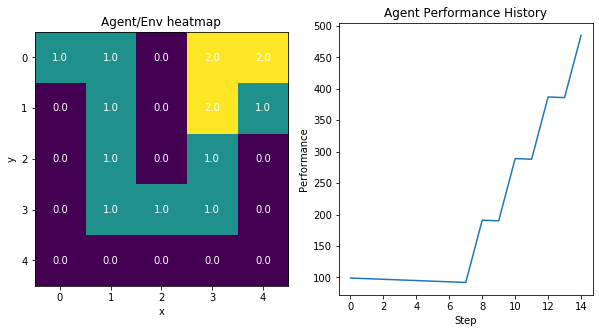


Sheep spent 0.0 steps on electric fence.



In [27]:
SIZE = 5
sheep = SearchAgent(initial_state=initial, goal=goal, location=[1,1])
_1play(sheep, size=SIZE)

print('\nGame completed in {} steps.'.format(len(sheep.tracker)))
AgentHeatMap(size=SIZE, agent=sheep, tracker=sheep.tracker)

<br>

![](./ML_R00183658_EXTRA_DIR/R00183658_reading.png)

**A perfect game run**  
The heatmap shows how the sheep was guided the shortest path around the fence (without ever touching it) straight to the grass.

<br>

---
---

### 1.3  Forward-Chaining and Backward Chaining

`NOTE:` Copied from Assignment for reference.

Forward-Chaining and Backward-Chaining introduces the capacity for inference in an environment.  How does this benefit the  
operation of an agent, in particularly in your world? Provide a short critical analysis of both approaches. Thereafter  
demonstrate their applicability by utilising them in your world  
(Note: if this requires a bending of the rules in your world that is ok - the important part is the discussion/analysis).

<br>

![](./ML_R00183658_EXTRA_DIR/R00183658_reading.png)

**Introduction**  
The introduction of Logic allows an agent to chose actions based on multiple perception along a time line.  
Therefore an agent is not bound to the percepts of the current state or data it stored in a model, but the use of logic instead provides  
a grammar to build more complex `sentences` describing the world. These sentences about the world can be represent facts the agent knows  
(single literals) or clauses involving multiple literals to describe more complex states. Additionally, these sentences are stored in a
knowledge base (KB).

By carefully modeling the KB and sentences in it, an agent could improve its performance in partially observable worlds when search  
is not applicable.

In order to use **Forward-Chaining (FC)** or **Backward Chaining (BC)** the above mentioned senteces need to be expressed as `definite` clauses  
which are a specialization of **Horn** clauses.
- a **definite** clause is a disjunction of literals of which exactly 1 literal is positive and are best described as **implications**
- a **Horn** clause is a generalization of a definite clause in which 0 or 1 literals are positive.

<br>

**Forward-Chaining**  
When using Forward-Chaining we have a KB with definite clauses and we ask this KB whether a query **q** is entailed by the content of   
the KB. Forward Chaining applies Modus Ponens inference rule to infer knowledge from the sentences the KB includes. It is said to be  
a **data-driven** inference, because the whole process starts with the fact the KB knows and then follows the implications that are satisfied  
by the fact literals. If **q** is entailed, the KB inference found a chain of Modus Ponens inferences that proof **q**, hence the name  
forward-chaining. A disadavantage of FC is that by staring from facts a lot of irrevlant inferences may be executed until finally a statement  
can be made whether **q** is entailed or not.

**Backward-chaining**  
Backward-chaining uses the same operations, but the main difference is that inference starts with the goal, i.e. **q**, and is said to be  
**goal-driven**. From the goal the KB first tries to proof the immediate implications that lead to **q** by recursively proofing the implications  
backwards to the facts inside the KB. Backward chaining can result in fewer inferences are only relevant inferences are executed: Those that  
have implications leading to **q** . E.g. if one of the direct implications leading to **q** are not satisfied, BC stops very quick the inference process.

<br>

**Applicability to agent world**  
For the Sheep World, these inference techniques can be used to infer future states from current and previous percepts and/or knowledge of the world  
and thus avoid malicious states.  
Imagine a Sheep2.0 that is capable of `sensing` electro-magnetic waves when next to a fence. A rule could say, that once electro-magnetic waves  
are noticed, one of the unexplored neighbor locations must include a fence. The sheep can now be very cautious and only choose as next action to  
move to locations that are known to be safe, i.e. return to previous location and continue to explore the world further away from risky a shock  
by a fence.  
In contrast to the search based techniques, now the sheep should be able to walk around the fence without even hitting it.


<br>

![](./ML_R00183658_EXTRA_DIR/R00183658_reading.png)

**Sample implementation**  
Below I implemented a small FC KB. The search stops when the KB entail the 3 locations of the fence.  
To avoid the Fence the sheep now is capable of sensing electro-magnetic waves (EMW) in locations next to a fence.  

4 initial clauses have been provided to the KB, each being an implication of a Fence in a location, if there are  
electro-magnetic waves in a neighbor location. `DONE` represents the goal, which now is not finding all Grass, but
rather locating all Fences.

In [28]:
def get_percept(location):
    percepts = ['EMW01', 'EMW11', 'EMW21', 'EMW32', 'EMW03', 'EMW13', 'EMW23']
    e = 'EMW{}{}'.format(location[0],location[1])
    return e in percepts

def update_KB(KB, location):
    if get_percept(location):
        KB.tell(expr('EMW{}{}'.format(location[0],location[1])))
    else:
        id = 'SAFE{}{}'.format(location[0],location[1])
        if not pl_fc_entails(sheep_KB, expr(id)):
            KB.tell(expr('SAFE{}{}'.format(location[0],location[1])))

def next_location(location):
    next_list = []
    x, y = int(location[0]), int(location[1])
    
    if x+1 <= 4:
        next_list.append([x+1, y])
    if y+1 <= 4:
        next_list.append([x, y+1])
    if x-1 >= 0:
        next_list.append([x-1, y])
    if y-1 >= 0:
        next_list.append([x, y-1])
    
    return next_list

def AgentHeatMap_KB(size, tracker, agent=None, random_game=None):
    map = np.zeros((size, size))
    for location in tracker:
        x, y = location[0], location[1]
        map[x][y] +=1
        
    if not agent:
        fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5,5))

        im = ax1.imshow(map)
        # Loop over data dimensions and create text annotations.
        for i in range(size):
            for j in range(size):
                text = ax1.text(j, i, map[i, j], ha="center", va="center", color="w")
        
    plt.show()
    
    if not random_game:
        steps_on_fence = map[0][2] + map[1][2] + map[2][2]
        print('\nSheep spent {} steps on electric fence.\n'.format(steps_on_fence))

In [29]:
#####################################
#
# Using pl_fc_entails from AIMA code
#
#####################################


location = [0,0]
tracker = [location]

clauses = [
    '(F02 & F12 & F22)==>DONE',
    '(EMW01 & EMW03)==>F02',
    '(EMW11 & EMW13)==>F12',
    '(EMW21 & EMW32 & EMW23)==>F22',
]

sheep_KB = PropDefiniteKB()
for clause in clauses:
    sheep_KB.tell(expr(clause))

print('KB:', sheep_KB.clauses)

update_KB(sheep_KB, location)
for i in range(1000):
    if pl_fc_entails(sheep_KB, expr('EMW{}{}'.format(location[0],location[1]))):
        location = tracker[-2]
    else:
        n = next_location(location)
        choice = random.choice(n)
        if not pl_fc_entails(sheep_KB, expr('EMW{}{}'.format(choice[0],choice[1]))) or pl_fc_entails(sheep_KB, expr('F{}{}'.format(choice[0],choice[1]))):
            location = choice
            update_KB(sheep_KB, location)
    
    tracker.append(location)
    
    if pl_fc_entails(sheep_KB, expr('DONE')):
        print('KB entails all Fences after {} rounds.'.format(i))
        break


KB: [(((F02 & F12) & F22) ==> DONE), ((EMW01 & EMW03) ==> F02), ((EMW11 & EMW13) ==> F12), (((EMW21 & EMW32) & EMW23) ==> F22)]
KB entails all Fences after 389 rounds.


In [30]:
sheep_KB.clauses

[(((F02 & F12) & F22) ==> DONE),
 ((EMW01 & EMW03) ==> F02),
 ((EMW11 & EMW13) ==> F12),
 (((EMW21 & EMW32) & EMW23) ==> F22),
 SAFE00,
 EMW01,
 SAFE10,
 SAFE20,
 SAFE30,
 SAFE31,
 EMW21,
 EMW32,
 SAFE40,
 EMW11,
 SAFE41,
 SAFE42,
 SAFE43,
 SAFE33,
 EMW23,
 SAFE44,
 SAFE34,
 SAFE24,
 SAFE14,
 EMW13,
 SAFE04,
 EMW03]

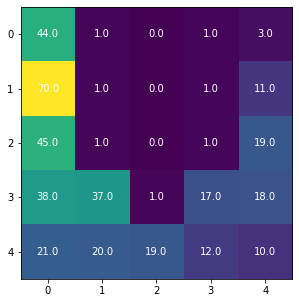


Sheep spent 0.0 steps on electric fence.



In [31]:
AgentHeatMap_KB(5, tracker)

<br>

![](./ML_R00183658_EXTRA_DIR/R00183658_reading.png)

This confirms that making KB-based inference and by making careful decisions when sensing EWR that sheep and move around the  
partially observable world without ever hitting a fence. A drawback is the large armount of unneccesary steps currently done